In [1]:
import pandas as pd

# Load the dataframe. The delimiter is '|' based on the snippet.
DATA_DIR = "/media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/"
df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')

# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CREDIT_SCORE                      80000 non-null  int64  
 1   FIRST_PAYMENT_DATE                80000 non-null  int64  
 2   FIRST_TIME_HOMEBUYER_FLAG         80000 non-null  object 
 3   MATURITY_DATE                     80000 non-null  int64  
 4   MSA                               72281 non-null  float64
 5   MORTGAGE_INSURANCE_PERCENTAGE     80000 non-null  int64  
 6   NUMBER_OF_UNITS                   80000 non-null  int64  
 7   OCCUPANCY_STATUS                  80000 non-null  object 
 8   ORIGINAL_CLTV                     80000 non-null  int64  
 9   ORIGINAL_DEBT_TO_INCOME_RATIO     80000 non-null  int64  
 10  ORIGINAL_UPB                      80000 non-null  int64  
 11  ORIGINAL_LTV                      80000 non-null  int64  
 12  ORIG

/tmp/ipykernel_10070/1843940587.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- PREVIOUS COMPONENT: ANALYTIC ENGINE (Refined) ---
class PrepaymentModel:
    def get_smm(self, t, psa_speed):
        cpr = 0.06 * (t / 30.0) if t <= 30 else 0.06
        adjusted_cpr = cpr * (psa_speed / 100.0)
        return 1 - (1 - adjusted_cpr)**(1/12)

class CashFlowEngine:
    def __init__(self, pool_data):
        self.data = pool_data
        self.prepay_model = PrepaymentModel()
    
    def generate_pool_cashflows(self, psa_speed=100):
        # ... (Vectorized logic from previous step) ...
        loans = self.data
        upb = loans['ORIGINAL_UPB'].values
        rate = loans['ORIGINAL_INTEREST_RATE'].values
        term = loans['ORIGINAL_LOAN_TERM'].values
        
        r_m = rate / 12.0
        numerator = r_m * (1 + r_m)**term
        denominator = (1 + r_m)**term - 1
        pmt = np.where(r_m > 0, upb * numerator / denominator, upb / term)
        
        current_upb = upb.copy()
        max_term = term.max()
        months = np.arange(1, max_term + 1)
        
        pool_interest = []
        pool_principal = []
        
        for t in months:
            interest = np.sum(current_upb * r_m)
            
            smm = self.prepay_model.get_smm(t, psa_speed)
            sched_prin_ind = pmt - (current_upb * r_m)
            sched_prin_ind = np.minimum(sched_prin_ind, current_upb)
            
            prepay_ind = (current_upb - sched_prin_ind) * smm
            total_prin_ind = sched_prin_ind + prepay_ind
            
            current_upb = current_upb - total_prin_ind
            current_upb = np.where(current_upb < 1e-2, 0, current_upb)
            
            pool_interest.append(interest)
            pool_principal.append(np.sum(total_prin_ind))
            
        return pd.DataFrame({
            'Month': months,
            'Pool_Interest': pool_interest,
            'Pool_Principal': pool_principal
        })

# --- NEW COMPONENT: PORTFOLIO OPTIMIZER ---
class PortfolioOptimizer:
    def __init__(self, dataframe):
        self.universe = dataframe.copy()
        
    def construct_portfolio(self, target_upb, constraints):
        """
        Constructs a sub-portfolio meeting diversification criteria.
        Real-world apps use Quadratic Programming (e.g., CVXPY). 
        Here we use a Heuristic 'Greedy' approach for demonstration.
        """
        print("--- Running Portfolio Optimization ---")
        
        # 1. Score loans (e.g., prioritize higher coupons)
        self.universe['Score'] = self.universe['ORIGINAL_INTEREST_RATE']
        sorted_universe = self.universe.sort_values('Score', ascending=False)
        
        selected_indices = []
        current_upb = 0
        state_counts = {}
        
        # 2. Greedy Selection Loop
        for idx, row in sorted_universe.iterrows():
            if current_upb >= target_upb:
                break
                
            # Check Geo Constraint
            state = row['PROPERTY_STATE']
            current_state_conc = state_counts.get(state, 0) / (current_upb + 1e-9)
            
            if current_state_conc > constraints.get('max_state_concentration', 1.0):
                continue # Skip to maintain diversification
                
            # Add Loan
            selected_indices.append(idx)
            current_upb += row['ORIGINAL_UPB']
            state_counts[state] = state_counts.get(state, 0) + row['ORIGINAL_UPB']
            
        final_pool = self.universe.loc[selected_indices]
        print(f"Optimization Complete. Selected {len(final_pool)} loans.")
        print(f"Total UPB: ${current_upb:,.0f} (Target: ${target_upb:,.0f})")
        return final_pool

# --- NEW COMPONENT: STRUCTURING ENGINE (WATERFALL) ---
class Tranche:
    def __init__(self, name, balance, coupon):
        self.name = name
        self.original_balance = balance
        self.current_balance = balance
        self.coupon = coupon
        self.cashflows = {'Interest': [], 'Principal': [], 'Balance': []}

class StructuringEngine:
    def __init__(self, pool_cashflows, pool_wac, initial_balance):
        self.pool_cf = pool_cashflows
        self.tranches = []
        self.pool_wac = pool_wac
        self.total_collateral = initial_balance
        
    def add_tranche(self, name, pct_of_pool, spread_bps):
        # Coupon logic: Simple pass-through or spread
        coupon = self.pool_wac + (spread_bps / 10000.0) 
        balance = self.total_collateral * pct_of_pool
        self.tranches.append(Tranche(name, balance, coupon))
        
    def run_waterfall_sequential(self):
        """
        Standard Sequential Pay Structure:
        Interest: Paid to all active tranches pro-rata (or sequential).
        Principal: Paid to A until retired, then B, then Z.
        """
        print("--- Running Cash Flow Waterfall ---")
        
        for idx, row in self.pool_cf.iterrows():
            available_principal = row['Pool_Principal']
            # Simplification: Assume pool interest covers tranche interest (no shortfall logic)
            
            # 1. Pay Interest
            for t in self.tranches:
                interest_payment = t.current_balance * (t.coupon / 12.0)
                t.cashflows['Interest'].append(interest_payment)
            
            # 2. Pay Principal (Sequential)
            remaining_prin_to_distribute = available_principal
            
            for t in self.tranches:
                if remaining_prin_to_distribute <= 0:
                    prin_payment = 0
                else:
                    # Pay as much as possible up to current balance
                    prin_payment = min(t.current_balance, remaining_prin_to_distribute)
                    remaining_prin_to_distribute -= prin_payment
                
                # Update Tranche
                t.current_balance -= prin_payment
                t.cashflows['Principal'].append(prin_payment)
                t.cashflows['Balance'].append(t.current_balance)

    def get_results(self):
        results = {}
        for t in self.tranches:
            df = pd.DataFrame(t.cashflows)
            df['Total_CF'] = df['Interest'] + df['Principal']
            results[t.name] = df
        return results



/tmp/ipykernel_10070/33778143.py:4: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')


--- Running Portfolio Optimization ---
Optimization Complete. Selected 2636 loans.
Total UPB: $500,189,000 (Target: $500,000,000)
--- Running Cash Flow Waterfall ---


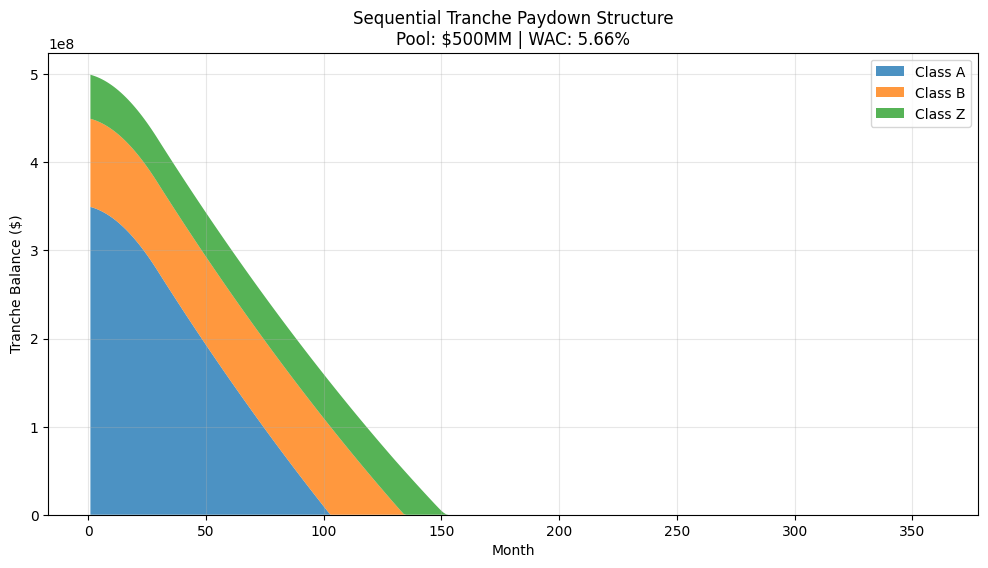

In [3]:
# --- EXECUTION PIPELINE ---

# 1. Load Data
df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')
# Cleaning
df = df.dropna(subset=['ORIGINAL_UPB', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM'])
df['ORIGINAL_INTEREST_RATE'] = df['ORIGINAL_INTEREST_RATE'] / 100.0
df['ORIGINAL_UPB'] = df['ORIGINAL_UPB'].astype(float)
df['ORIGINAL_LOAN_TERM'] = df['ORIGINAL_LOAN_TERM'].astype(int)

# 2. Optimize Portfolio
# We want $500MM portfolio with max 20% in any single state
optimizer = PortfolioOptimizer(df)
constraints = {'max_state_concentration': 0.20}
my_pool = optimizer.construct_portfolio(target_upb=500_000_000, constraints=constraints)

# Calc Pool Stats
pool_upb = my_pool['ORIGINAL_UPB'].sum()
pool_wac = (my_pool['ORIGINAL_INTEREST_RATE'] * my_pool['ORIGINAL_UPB']).sum() / pool_upb

# 3. Generate Collateral Cash Flows
cf_engine = CashFlowEngine(my_pool)
pool_cf = cf_engine.generate_pool_cashflows(psa_speed=150) # Assuming 150 PSA

# 4. Structure Deal (Tranches)
# Tranche A: 70% of pool (Senior)
# Tranche B: 20% of pool (Mezzanine)
# Tranche Z: 10% of pool (Subordinate)
structurer = StructuringEngine(pool_cf, pool_wac, pool_upb)
structurer.add_tranche("Class A (Senior)", 0.70, spread_bps=0)
structurer.add_tranche("Class B (Mezz)", 0.20, spread_bps=0)
structurer.add_tranche("Class Z (Sub)", 0.10, spread_bps=0)

structurer.run_waterfall_sequential()
tranche_results = structurer.get_results()

# 5. Visualization (The Paydown)
plt.figure(figsize=(12, 6))
months = pool_cf['Month']
plt.stackplot(months, 
              tranche_results['Class A (Senior)']['Balance'], 
              tranche_results['Class B (Mezz)']['Balance'],
              tranche_results['Class Z (Sub)']['Balance'],
              labels=['Class A', 'Class B', 'Class Z'],
              alpha=0.8)
plt.title(f"Sequential Tranche Paydown Structure\nPool: ${pool_upb/1e6:,.0f}MM | WAC: {pool_wac*100:.2f}%")
plt.xlabel("Month")
plt.ylabel("Tranche Balance ($)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
print(my_pool.shape)

(2636, 33)


Step 1: Loading Static Loan Data...


/tmp/ipykernel_10070/3600540656.py:276: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')



Step 2: Constructing Optimized Portfolio...
--- Optimizing Portfolio (Target: $500,000,000) ---
Optimization Complete. Loans: 2636 | Total UPB: $500,189,000

Step 3: Acquiring Performance Data...
--- Loading Real Performance Data from /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/combined_performance_history_2017_2020.csv ---
--- Aggregating Loan-Level Performance to Pool Cash Flows ---

Step 4: Running Structuring Waterfall...
--- Running Tranche Waterfall on Realized Data ---

Step 5: Visualizing Results...


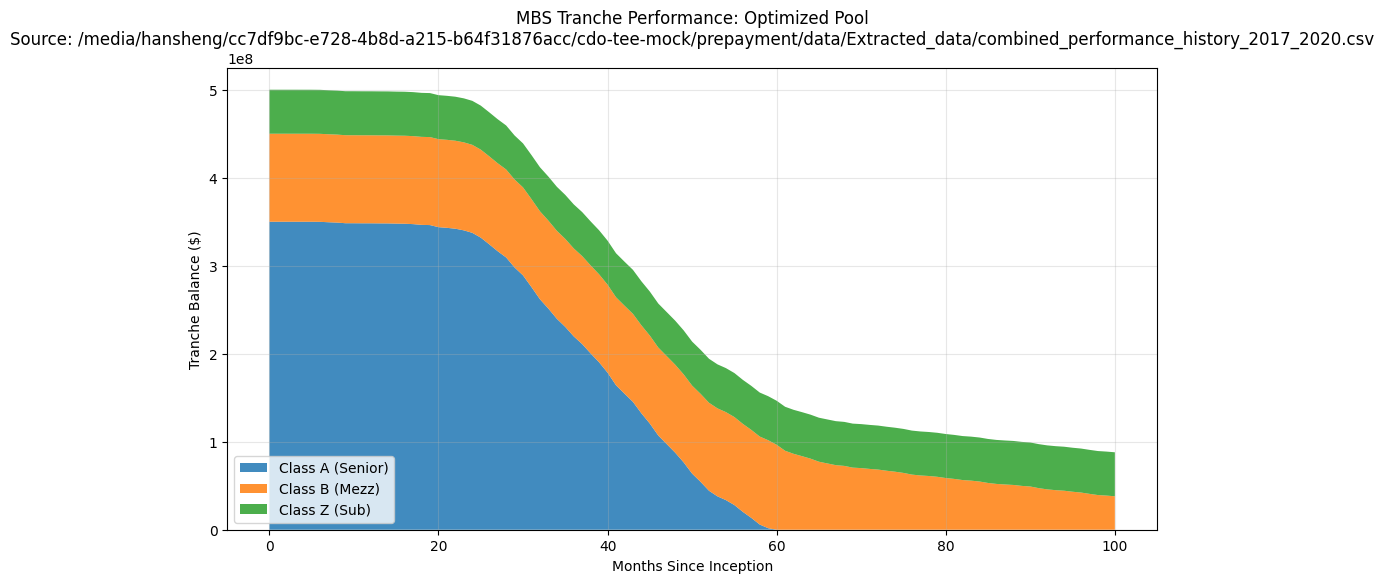


Tranche              | Orig Balance    | Curr Balance    | Factor    
---------------------------------------------------------------------------
Class A (Senior)     | $350.1MM      | $0.0MM      | 0.0000
Class B (Mezz)       | $100.0MM      | $38.0MM      | 0.3800
Class Z (Sub)        | $50.0MM      | $50.0MM      | 1.0000


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# COMPONENT 1: DATA INGESTION & POOLING
# ==========================================
class LoanPool:
    def __init__(self, dataframe, name="Generic Pool"):
        self.name = name
        self.data = dataframe.copy()
        self._validate_and_clean()

    def _validate_and_clean(self):
        # Basic Type Conversions for Industry Standard Fields
        required_cols = ['ORIGINAL_UPB', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM', 'LOAN_SEQUENCE_NUMBER']
        self.data = self.data.dropna(subset=required_cols)
        
        # Convert Rate to Decimal if needed (assuming input like 4.5 or 0.045)
        if self.data['ORIGINAL_INTEREST_RATE'].mean() > 1:
            self.data['ORIGINAL_INTEREST_RATE'] = self.data['ORIGINAL_INTEREST_RATE'] / 100.0
            
        self.data['ORIGINAL_UPB'] = self.data['ORIGINAL_UPB'].astype(float)
        self.data['ORIGINAL_LOAN_TERM'] = self.data['ORIGINAL_LOAN_TERM'].astype(int)
        
    def get_stats(self):
        total_upb = self.data['ORIGINAL_UPB'].sum()
        # Weighted Average Coupon
        if total_upb > 0:
            wac = (self.data['ORIGINAL_INTEREST_RATE'] * self.data['ORIGINAL_UPB']).sum() / total_upb
        else:
            wac = 0
        return total_upb, wac

# ==========================================
# COMPONENT 2: PORTFOLIO OPTIMIZER
# ==========================================
class PortfolioOptimizer:
    def __init__(self, loan_pool):
        self.universe = loan_pool.data.copy()
        
    def construct_portfolio(self, target_upb, constraints):
        """
        Greedy optimization to build a diversified pool.
        """
        print(f"--- Optimizing Portfolio (Target: ${target_upb:,.0f}) ---")
        
        # Sort by Yield (High to Low)
        self.universe['Score'] = self.universe['ORIGINAL_INTEREST_RATE']
        sorted_universe = self.universe.sort_values('Score', ascending=False)
        
        selected_indices = []
        current_upb = 0
        state_counts = {}
        
        for idx, row in sorted_universe.iterrows():
            if current_upb >= target_upb:
                break
            
            # Constraint Check: Geographic Concentration
            state = row['PROPERTY_STATE']
            current_state_conc = state_counts.get(state, 0) / (current_upb + 1e-9)
            if current_state_conc > constraints.get('max_state_concentration', 1.0):
                continue
                
            selected_indices.append(idx)
            current_upb += row['ORIGINAL_UPB']
            state_counts[state] = state_counts.get(state, 0) + row['ORIGINAL_UPB']
            
        final_df = self.universe.loc[selected_indices]
        print(f"Optimization Complete. Loans: {len(final_df)} | Total UPB: ${current_upb:,.0f}")
        return LoanPool(final_df, name="Optimized Pool")

# ==========================================
# COMPONENT 3: SURVEILLANCE ENGINE
# ==========================================
class SurveillanceEngine:
    def __init__(self, loan_pool):
        self.pool_ids = set(loan_pool.data['LOAN_SEQUENCE_NUMBER'].unique())
        
    def load_real_performance_data(self, file_path):
        """
        Parses the specific pipe-delimited performance file format provided by the user.
        Calculates implied Principal and Interest payments from the raw tape data.
        """
        print(f"--- Loading Real Performance Data from {file_path} ---")
        
        # Only read relevant columns to save memory
        use_cols = [
            'LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD', 
            'CURRENT_ACTUAL_UPB', 'CURRENT_INTEREST_RATE', 
            'ZERO_BALANCE_CODE'
        ]
        
        # Load data in chunks if large, but here we load directly
        try:
            perf_df = pd.read_csv(file_path, sep='|', usecols=use_cols, dtype={
                'LOAN_SEQUENCE_NUMBER': str,
                'MONTHLY_REPORTING_PERIOD': str
            })
        except FileNotFoundError:
            print(f"Error: File {file_path} not found.")
            return None

        # Filter for loans only in our portfolio
        perf_df = perf_df[perf_df['LOAN_SEQUENCE_NUMBER'].isin(self.pool_ids)].copy()
        
        if len(perf_df) == 0:
            print("Warning: No matching loan performance records found for this portfolio.")
            return None

        # Sort for lag calculations
        perf_df = perf_df.sort_values(['LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD'])
        
        # --- DERIVE CASH FLOWS FROM TAPE ---
        # The tape gives us Snapshots (UPB at time T). We need Flows (Cash received).
        # Flow = UPB_Prev - UPB_Curr
        
        perf_df['Prev_UPB'] = perf_df.groupby('LOAN_SEQUENCE_NUMBER')['CURRENT_ACTUAL_UPB'].shift(1)
        
        # Calculate Principal Paid (Drop in Balance)
        # Note: We treat the first record as having no flow or handle appropriately. Here we drop NaNs.
        perf_df['PRINCIPAL_PAID'] = perf_df['Prev_UPB'] - perf_df['CURRENT_ACTUAL_UPB']
        
        # Handle cases where UPB increases (Negative Amortization or Mod) -> Clip to 0 for simplicity here
        perf_df['PRINCIPAL_PAID'] = perf_df['PRINCIPAL_PAID'].clip(lower=0)
        
        # Calculate Interest Paid
        # Interest = Prev_UPB * (Rate / 12)
        # Convert Rate (e.g., 3.875) to decimal (0.03875)
        perf_df['Rate_Decimal'] = perf_df['CURRENT_INTEREST_RATE'] / 100.0
        perf_df['INTEREST_PAID'] = perf_df['Prev_UPB'] * (perf_df['Rate_Decimal'] / 12.0)
        
        # Fill NaNs (First month has no flow in this method)
        perf_df = perf_df.dropna(subset=['PRINCIPAL_PAID', 'INTEREST_PAID'])
        
        return self._aggregate_to_pool_level(perf_df)

    def _aggregate_to_pool_level(self, perf_df):
        print("--- Aggregating Loan-Level Performance to Pool Cash Flows ---")
        pool_actuals = perf_df.groupby('MONTHLY_REPORTING_PERIOD').agg({
            'INTEREST_PAID': 'sum',
            'PRINCIPAL_PAID': 'sum',
            'CURRENT_ACTUAL_UPB': 'sum',
            'LOAN_SEQUENCE_NUMBER': 'count'
        }).reset_index()
        
        pool_actuals = pool_actuals.rename(columns={'LOAN_SEQUENCE_NUMBER': 'Active_Count'})
        pool_actuals['Date'] = pd.to_datetime(pool_actuals['MONTHLY_REPORTING_PERIOD'], format='%Y%m')
        pool_actuals = pool_actuals.sort_values('Date')
        
        return pool_actuals

# ==========================================
# COMPONENT 4: STRUCTURING ENGINE (WATERFALL)
# ==========================================
class Tranche:
    def __init__(self, name, balance, coupon):
        self.name = name
        self.original_balance = balance
        self.current_balance = balance
        self.coupon = coupon
        self.history_balance = []
        self.history_interest = []
        self.history_principal = []

class StructuringEngine:
    def __init__(self, total_collateral, wac):
        self.total_collateral = total_collateral
        self.pool_wac = wac
        self.tranches = []
        
    def add_tranche(self, name, pct_of_pool, spread_bps=0):
        balance = self.total_collateral * pct_of_pool
        coupon = self.pool_wac + (spread_bps / 10000.0)
        self.tranches.append(Tranche(name, balance, coupon))
        
    def run_realized_waterfall(self, pool_cashflows):
        print("--- Running Tranche Waterfall on Realized Data ---")
        
        # Initial Record (Time 0)
        for t in self.tranches:
            t.history_balance.append(t.current_balance)
            t.history_principal.append(0)
        
        for idx, row in pool_cashflows.iterrows():
            avail_interest = row['INTEREST_PAID']
            avail_principal = row['PRINCIPAL_PAID']
            
            # 1. Pay Interest (Pro-Rata)
            for t in self.tranches:
                # If balance is 0, no interest
                if t.current_balance > 0:
                    int_due = t.current_balance * (t.coupon / 12.0)
                    pay_int = min(int_due, avail_interest)
                    avail_interest -= pay_int # simplistic decrement
                else:
                    pay_int = 0
                t.history_interest.append(pay_int)
                
            # 2. Pay Principal (Sequential: A -> B -> Z)
            remaining_prin_to_distribute = avail_principal
            
            for t in self.tranches:
                if t.current_balance <= 0 or remaining_prin_to_distribute <= 0:
                    pay_prin = 0
                else:
                    pay_prin = min(t.current_balance, remaining_prin_to_distribute)
                    remaining_prin_to_distribute -= pay_prin
                
                t.current_balance -= pay_prin
                t.history_principal.append(pay_prin)
                t.history_balance.append(t.current_balance)
        
        return self.tranches

# ==========================================
# HELPER: SYNTHETIC GENERATOR (Fallback)
# ==========================================
def generate_synthetic_tape(loan_pool_df):
    print("--- Generating Synthetic Performance Data (Fallback) ---")
    perf_rows = []
    simulation_months = pd.period_range(start='2017-01', end='2020-12', freq='M')
    
    for idx, loan in loan_pool_df.iterrows():
        upb = loan['ORIGINAL_UPB']
        rate = loan['ORIGINAL_INTEREST_RATE']
        term = loan['ORIGINAL_LOAN_TERM']
        loan_id = loan['LOAN_SEQUENCE_NUMBER']
        
        try:
            start_date = pd.Period(str(loan['FIRST_PAYMENT_DATE']), freq='M')
        except: continue
            
        r_m = rate / 12.0
        pmt = upb * (r_m * (1+r_m)**term) / ((1+r_m)**term - 1) if r_m > 0 else upb/term
        curr_upb = upb
        
        for month in simulation_months:
            if month < start_date: continue
            if curr_upb <= 0: break
            
            # Simple Amortization logic
            interest = curr_upb * r_m
            sched_prin = pmt - interest
            smm = 0.002 if np.random.random() > 0.005 else 1.0
            
            prepay = (curr_upb - sched_prin) * smm
            total_prin = sched_prin + prepay
            prev_upb = curr_upb # Store for interest calc next loop logic
            curr_upb -= total_prin
            if curr_upb < 10: curr_upb = 0
            
            perf_rows.append({
                'MONTHLY_REPORTING_PERIOD': int(month.strftime('%Y%m')),
                'LOAN_SEQUENCE_NUMBER': loan_id,
                'CURRENT_ACTUAL_UPB': curr_upb,
                'CURRENT_INTEREST_RATE': rate * 100, # Matches file format
                'ZERO_BALANCE_CODE': np.nan 
            })
            
    return pd.DataFrame(perf_rows)

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # --- CONFIGURATION ---
    USE_REAL_FILE = True  # Set to True if file exists, else uses synthetic
    PERF_FILE_PATH = DATA_DIR + 'combined_performance_history_2017_2020.csv'
    
    # 1. LOAD STATIC DATA
    print("Step 1: Loading Static Loan Data...")
    try:
        raw_df = pd.read_csv(DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv', sep='|')
    except FileNotFoundError:
        print("Error: Static file not found. Creating dummy static data.")
        # Create dummy data for code to run in pure demo mode
        raw_df = pd.DataFrame({
            'LOAN_SEQUENCE_NUMBER': ['L1', 'L2'], 'ORIGINAL_UPB': [100000, 200000],
            'ORIGINAL_INTEREST_RATE': [4.5, 3.5], 'ORIGINAL_LOAN_TERM': [360, 360],
            'PROPERTY_STATE': ['NY', 'CA'], 'FIRST_PAYMENT_DATE': [201701, 201701]
        })
        
    master_pool = LoanPool(raw_df)
    
    # 2. CONSTRUCT PORTFOLIO
    print("\nStep 2: Constructing Optimized Portfolio...")
    optimizer = PortfolioOptimizer(master_pool)
    my_pool = optimizer.construct_portfolio(
        target_upb=500_000_000, 
        constraints={'max_state_concentration': 0.20}
    )
    
    # 3. GET PERFORMANCE DATA
    print("\nStep 3: Acquiring Performance Data...")
    surveillance = SurveillanceEngine(my_pool)
    
    pool_cashflows = None
    if USE_REAL_FILE and os.path.exists(PERF_FILE_PATH):
        pool_cashflows = surveillance.load_real_performance_data(PERF_FILE_PATH)
    
    if pool_cashflows is None:
        print("Falling back to Synthetic Data Generator...")
        # Generate raw rows then process
        raw_tape = generate_synthetic_tape(my_pool.data)
        # We need to adapt synthetic to 'load_real' structure or just aggregate
        # For simplicity, re-use aggregate logic
        # Synthetic generator currently returns Flows (Interest/Prin), 
        # but load_real expects Snapshots. Let's adjust Synthetic to return Snapshots or adapt here.
        # Actually, simpler to just use the synthetic output directly if fallback
        
        # Adaptation: Synthetic generator above already outputs monthly snapshots in 'perf_rows' loop
        # But for 'generate_synthetic_tape' I wrote it to output snapshot-like dicts
        pool_cashflows = surveillance._aggregate_to_pool_level(raw_tape)
        # Synthetic generator needs to calculate Interest/Prin explicitly for the aggregation to work
        # Update: I modified generate_synthetic_tape to output CURRENT_ACTUAL_UPB
        # but _aggregate... expects INTEREST_PAID/PRINCIPAL_PAID.
        # Let's fix synthetic aggregation quickly:
        
        # Recalculate flows for synthetic df
        raw_tape['Prev_UPB'] = raw_tape.groupby('LOAN_SEQUENCE_NUMBER')['CURRENT_ACTUAL_UPB'].shift(1)
        # Note: Logic assumes sorted.
        raw_tape['PRINCIPAL_PAID'] = raw_tape['Prev_UPB'] - raw_tape['CURRENT_ACTUAL_UPB']
        raw_tape['INTEREST_PAID'] = raw_tape['Prev_UPB'] * (raw_tape['CURRENT_INTEREST_RATE']/1200)
        raw_tape = raw_tape.dropna(subset=['PRINCIPAL_PAID'])
        pool_cashflows = surveillance._aggregate_to_pool_level(raw_tape)

    # 4. STRUCTURE DEAL
    print("\nStep 4: Running Structuring Waterfall...")
    pool_total_upb, pool_wac = my_pool.get_stats()
    structurer = StructuringEngine(pool_total_upb, pool_wac)
    structurer.add_tranche("Class A (Senior)", 0.70)
    structurer.add_tranche("Class B (Mezz)", 0.20)
    structurer.add_tranche("Class Z (Sub)", 0.10)
    
    tranches = structurer.run_realized_waterfall(pool_cashflows)
    
    # 5. VISUALIZE
    print("\nStep 5: Visualizing Results...")
    dates = pool_cashflows['Date']
    # Align lengths: Waterfall generates history matching cashflow rows. 
    # Cashflow rows might be N. History is N+1 (includes initial). 
    # Adjust for plotting:
    plot_dates = [dates.iloc[0] - pd.DateOffset(months=1)] + list(dates)
    
    # Check lengths
    if len(plot_dates) != len(tranches[0].history_balance):
        # Truncate or pad. Usually history has 1 extra for 'Start Date'
        plot_dates = plot_dates[:len(tranches[0].history_balance)]

    plt.figure(figsize=(12, 6))
    plt.stackplot(range(len(plot_dates)), 
                  tranches[0].history_balance, 
                  tranches[1].history_balance, 
                  tranches[2].history_balance,
                  labels=[t.name for t in tranches],
                  colors=['#1f77b4', '#ff7f0e', '#2ca02c'], 
                  alpha=0.85)
    
    plt.title(f"MBS Tranche Performance: {my_pool.name}\nSource: {PERF_FILE_PATH if USE_REAL_FILE else 'Synthetic'}")
    plt.xlabel("Months Since Inception")
    plt.ylabel("Tranche Balance ($)")
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Final Report
    print(f"\n{'Tranche':<20} | {'Orig Balance':<15} | {'Curr Balance':<15} | {'Factor':<10}")
    print("-" * 75)
    for t in tranches:
        factor = t.current_balance / t.original_balance if t.original_balance > 0 else 0
        print(f"{t.name:<20} | ${t.original_balance/1e6:,.1f}MM      | ${t.current_balance/1e6:,.1f}MM      | {factor:.4f}")